<a href="https://colab.research.google.com/github/TBeatrix/Deep_learning_nagyhazi/blob/main/milestone1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning I. Milestone**



---



---



**Team name: Pain & Panic**

team members: T63K63 - Tugyi Beatrix,
              IT9P0Z - Heizer Levente

In [ ]:
from sklearn.model_selection import train_test_split
import torch

In [38]:
!pip freeze


absl-py==1.4.0
aiohttp==3.8.6
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.4.1
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.1.0
audioread==3.0.1
autograd==1.6.2
Babel==2.13.0
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.8.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.2.2
bqplot==0.12.42
branca==0.6.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.1
catalogue==2.0.10
certifi==2023.7.22
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.0
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.7
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.3
cons==0.4.6
contextlib2==21.6.0
contourpy==1.1.1
cryptography==41.0.4
csrgraph==0.1.28
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.2
cvxpy==1.3.2
c

In [1]:
!pip install nodevectors

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for nodevectors: filename=nodevectors-0.1.23-py3-none-any.whl size=17928 sha256=b75a6138bc9205ea84ccd1ce2ab13fb1b78512f60ce39de007b8f37d4a169099
  Stored in directory: /root/.cache/pip/wheels/b5/4c/91/bf05a408dda66b136034cf5c91e4a40381fc01aa0f5ecd8f89
  Created wheel for csrgraph: filename=csrgraph-0.1.28-py3-none-any.whl size=17615 sha256=3498eecc6c473721413082d942585a3b0668df232f449071c53cf1ae33d70493
  Stored in directory: /root/.cache/pip/wheels/0f/b5/63/fd61f029bb51e69d1d3ab578bc3361159f52bd99e46bd8d5c3
Successfully built nodevectors csrgraph


In [2]:
!pip install gensim


In [3]:
import re
#!pip install nodevectors== 0.1.0
import networkx as nx

from nodevectors import Node2Vec
import matplotlib.pyplot as plt


In [4]:
nx.adj_matrix = nx.adjacency_matrix

In [5]:
import numba
import numpy as np
import pandas as pd
import time
import warnings

# Gensim triggers automatic useless warnings for windows users...
warnings.simplefilter("ignore", category=UserWarning)
import gensim
warnings.simplefilter("default", category=UserWarning)


import csrgraph as cg
from nodevectors.embedders import BaseNodeEmbedder

class Node2Vec(BaseNodeEmbedder):
    def __init__(
        self,
        n_components=32,
        walklen=30,
        epochs=20,
        return_weight=1.,
        neighbor_weight=1.,
        threads=0,
        keep_walks=False,
        verbose=True,
        w2vparams={"window":10, "negative":5, "iter":10,
                   "batch_words":128}):
        """
        Parameters
        ----------
        walklen : int
            length of the random walks
        epochs : int
            number of times to start a walk from each nodes
        threads : int
            number of threads to use. 0 is full use
        n_components : int
            number of resulting dimensions for the embedding
            This should be set here rather than in the w2vparams arguments
        return_weight : float in (0, inf]
            Weight on the probability of returning to node coming from
            Having this higher tends the walks to be
            more like a Breadth-First Search.
            Having this very high  (> 2) makes search very local.
            Equal to the inverse of p in the Node2Vec paper.
        neighbor_weight : float in (0, inf]
            Weight on the probability of visitng a neighbor node
            to the one we're coming from in the random walk
            Having this higher tends the walks to be
            more like a Depth-First Search.
            Having this very high makes search more outward.
            Having this very low makes search very local.
            Equal to the inverse of q in the Node2Vec paper.
        keep_walks : bool
            Whether to save the random walks in the model object after training
        w2vparams : dict
            dictionary of parameters to pass to gensim's word2vec
            Don't set the embedding dimensions through arguments here.
        """
        if type(threads) is not int:
            raise ValueError("Threads argument must be an int!")
        if walklen < 1 or epochs < 1:
            raise ValueError("Walklen and epochs arguments must be > 1")
        self.n_components = n_components
        self.walklen = walklen
        self.epochs = epochs
        self.keep_walks = keep_walks
        if 'size' in w2vparams.keys():
            raise AttributeError("Embedding dimensions should not be set "
                + "through w2v parameters, but through n_components")
        self.w2vparams = w2vparams
        self.return_weight = return_weight
        self.neighbor_weight = neighbor_weight
        if threads == 0:
            threads = numba.config.NUMBA_DEFAULT_NUM_THREADS
        self.threads = threads
        w2vparams['workers'] = threads
        self.verbose = verbose

    def fit(self, G):
        """
        NOTE: Currently only support str or int as node name for graph
        Parameters
        ----------
        G : graph data
            Graph to embed
            Can be any graph type that's supported by csrgraph library
            (NetworkX, numpy 2d array, scipy CSR matrix, CSR matrix components)
        """
        if not isinstance(G, cg.csrgraph):
            G = cg.csrgraph(G, threads=self.threads)
        if G.threads != self.threads:
            G.set_threads(self.threads)
        # Because networkx graphs are actually iterables of their nodes
        #   we do list(G) to avoid networkx 1.X vs 2.X errors
        node_names = G.names
        if type(node_names[0]) not in [int, str, np.int32, np.uint32,
                                       np.int64, np.uint64]:
            raise ValueError("Graph node names must be int or str!")
        # Adjacency matrix
        walks_t = time.time()
        if self.verbose:
            print("Making walks...", end=" ")
        self.walks = G.random_walks(walklen=self.walklen,
                                    epochs=self.epochs,
                                    return_weight=self.return_weight,
                                    neighbor_weight=self.neighbor_weight)
        if self.verbose:
            print(f"Done, T={time.time() - walks_t:.2f}")
            print("Mapping Walk Names...", end=" ")
        map_t = time.time()
        self.walks = pd.DataFrame(self.walks)
        # Map nodeId -> node name
        node_dict = dict(zip(np.arange(len(node_names)), node_names))
        for col in self.walks.columns:
            self.walks[col] = self.walks[col].map(node_dict).astype(str)
        # Somehow gensim only trains on this list iterator
        # it silently mistrains on array input
        self.walks = [list(x) for x in self.walks.itertuples(False, None)]
        if self.verbose:
            print(f"Done, T={time.time() - map_t:.2f}")
            print("Training W2V...", end=" ")
            if gensim.models.word2vec.FAST_VERSION < 1:
                print("WARNING: gensim word2vec version is unoptimized"
                    "Try version 3.6 if on windows, versions 3.7 "
                    "and 3.8 have had issues")
        w2v_t = time.time()
        # Train gensim word2vec model on random walks
        self.model = gensim.models.Word2Vec(
            sentences=self.walks,
            vector_size=self.n_components, #!!!!
            **self.w2vparams)
        if not self.keep_walks:
            del self.walks
        if self.verbose:
            print(f"Done, T={time.time() - w2v_t:.2f}")

    def fit_transform(self, G):
        """
        NOTE: Currently only support str or int as node name for graph
        Parameters
        ----------
        G : graph data
            Graph to embed
            Can be any graph type that's supported by csrgraph library
            (NetworkX, numpy 2d array, scipy CSR matrix, CSR matrix components)
        """
        if not isinstance(G, cg.csrgraph):
            G = cg.csrgraph(G, threads=self.threads)
        self.fit(G)
        w = np.array(
            pd.DataFrame.from_records(
            pd.Series(np.arange(len(G.nodes())))
              .apply(self.predict)
              .values)
        )
        return w

    def predict(self, node_name):
        """
        Return vector associated with node
        node_name : str or int
            either the node ID or node name depending on graph format
        """
        # current hack to work around word2vec problem
        # ints need to be str -_-
        if type(node_name) is not str:
            node_name = str(node_name)
        return self.model.wv.__getitem__(node_name)

    def save_vectors(self, out_file):
        """
        Save as embeddings in gensim.models.KeyedVectors format
        """
        self.model.wv.save_word2vec_format(out_file)

    def load_vectors(self, out_file):
        """
        Load embeddings from gensim.models.KeyedVectors format
        """
        self.model = gensim.wv.load_word2vec_format(out_file)

In [6]:
def get_ego_indexes(files):
  pattern = re.compile(r'\d+')
  ego_indexes = [int(pattern.search(s).group()) for s in files if pattern.search(s)]
  ego_indexes = sorted(set(ego_indexes))
  return ego_indexes

In [30]:
class GraphData:
  edge_index = []
  edge_list = []
  nodes = []
  X = []
  circles = []
  X_names = []
  embeddings = []
  train_mask = []
  test_mask = []
  val_mask = []

  def __init__(self, edges, edge_list, X, circles, X_names, embeddings, nodes, train_mask, test_mask, val_mask):
    self.edge_index = edges
    self.edge_list = edge_list
    self.X = X
    self.circles = circles
    self.X_names = X_names
    self.embeddings = embeddings
    self.nodes = nodes
    self.train_mask = train_mask
    self.test_mask = test_mask
    self.val_mask = val_mask

In [31]:
def visualize(g, title="Graph", edge='blue'):
    pos = nx.kamada_kawai_layout(g)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.axis('on')
    nx.draw_networkx(g, pos=pos, node_size=10,
                     arrows=False, width=1, style='solid', with_labels= False)
    plt.show()

#Facebook

Data acquisition: indicating the data source, and how you downloaded it (Python script or IPYNB)

In [9]:
!wget https://snap.stanford.edu/data/facebook.tar.gz

--2023-10-22 14:55:39--  https://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz’

facebook.tar.gz     100%[===================>] 714.95K  1.04MB/s    in 0.7s    

2023-10-22 14:55:40 (1.04 MB/s) - ‘facebook.tar.gz’ saved [732104/732104]



In [10]:
files = ! tar xvzf facebook.tar.gz

In [11]:
Fb_ego_indexes = get_ego_indexes(files)

In [ ]:
!pip install gensim==3.6

In [32]:
Facebook_graphs = []

In [35]:
for index in range(len(Fb_ego_indexes)-1):
  f = open(f'facebook/{Fb_ego_indexes[index]}.edges', "rt")
  edges_str = f.readlines()
  edges = [list(map(int, item.strip().split())) for item in edges_str]
  # Transpose the data to get desired format
  edges = [list(row) for row in zip(*edges)]

  edge_list =   [(int(x.split()[0]), int(x.split()[1])) for x in edges_str]
  f = open(f'facebook/{Fb_ego_indexes[index]}.circles', "rt")
  circles_str = f.readlines()
  circles = [list(map(int, item.split('\t')[1:])) for item in circles_str]

  f = open(f'facebook/{Fb_ego_indexes[index]}.featnames', "rt")
  feat_name_str = f.readlines()
  X_names = [item.split(';anonymized feature')[0].split(';') for item in feat_name_str]

  f = open(f'facebook/{Fb_ego_indexes[index]}.egofeat', "rt")
  feat_str = f.readlines()
  X = []
  X.append(list(map(int, feat_str[0].split()[1:])))

  f = open(f'facebook/{Fb_ego_indexes[index]}.feat', "rt")
  feat_str = f.readlines()
  X.append([list(map(int, item.split()[1:])) for item in feat_str])


  # Node2Vec expects an NX graph
  G  = nx.from_edgelist(edge_list)
  # Node2Vec model specification
  n2v = Node2Vec(n_components=64, walklen=10, epochs=50, return_weight=1.0, neighbor_weight=1.0, threads=0, w2vparams={'window': 4, 'negative': 5, 'epochs':10, 'ns_exponent': 0.5, 'batch_words': 128})
  # Fit and get the embedding

  n2v.fit(G)
  nodes = G.nodes()
  embeddings = []
  for node in nodes:
    embeddings.append(n2v.predict(node))

  idx = torch.arange(len(nodes))
  train_idx, test_idx = train_test_split(idx, train_size=0.8,  random_state=17)
  val_idx, test_idx = train_test_split(test_idx, train_size=0.5,  random_state=17)

  Facebook_graphs.append(GraphData(edges, edge_list, X, circles, X_names, embeddings, nodes, train_idx, test_idx, val_idx))

Making walks... Done, T=0.05
Mapping Walk Names... Done, T=0.29
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=4.59
Making walks... Done, T=0.10
Mapping Walk Names... Done, T=0.39
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=12.86
Making walks... Done, T=0.02
Mapping Walk Names... Done, T=0.10
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=3.04
Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.07
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=1.40
Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.07
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 

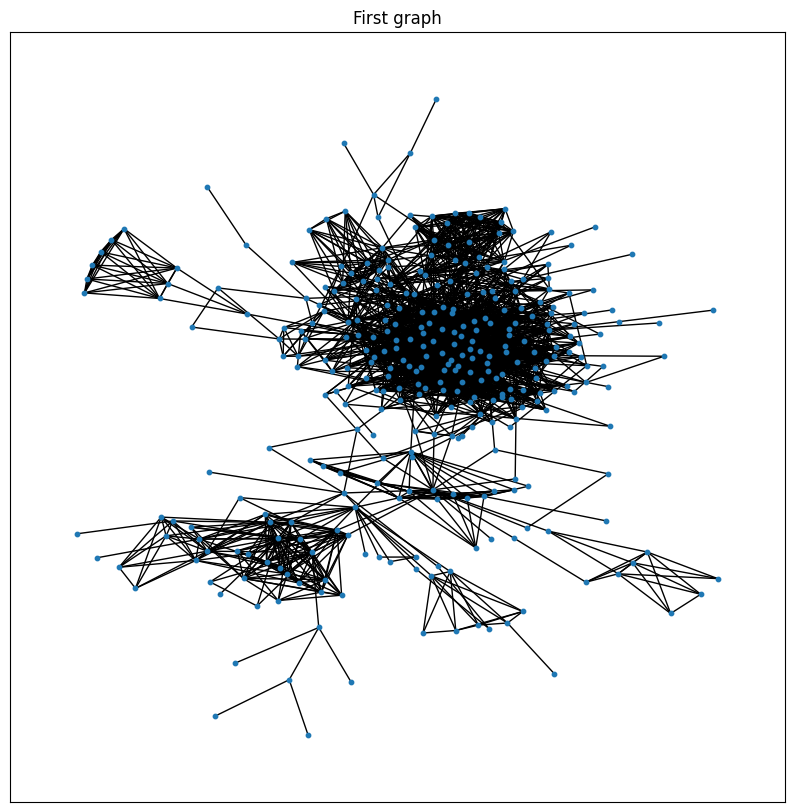

In [14]:
Edge_graph = nx.from_edgelist(Facebook_graphs[0].edge_list)
visualize( Edge_graph, "First graph")

In [ ]:
!pip freeze

absl-py==1.4.0
aiohttp==3.8.6
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.4.1
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.1.0
audioread==3.0.1
autograd==1.6.2
Babel==2.13.0
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.8.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.2.2
bqplot==0.12.42
branca==0.6.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.1
catalogue==2.0.10
certifi==2023.7.22
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.0
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.7
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.3
cons==0.4.6
contextlib2==21.6.0
contourpy==1.1.1
cryptography==41.0.4
csrgraph==0.1.28
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.2
cvxpy==1.3.2
c

In [36]:
Facebook_graphs[0].test_mask

tensor([245, 223, 191, 231, 173, 118, 128, 213, 321, 109, 218, 183,  11, 329,
        116, 156, 260, 230,  35,  62,  95, 125, 153, 161, 139, 244, 199, 108,
        182, 155,   6, 226, 257, 284])

In [15]:
Facebook_graphs[0].X[0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0]

In [16]:
Facebook_graphs[0].edge_index

[[236,
  122,
  24,
  271,
  176,
  130,
  204,
  252,
  82,
  276,
  280,
  211,
  84,
  133,
  239,
  322,
  3,
  175,
  170,
  170,
  254,
  231,
  127,
  285,
  188,
  23,
  73,
  288,
  119,
  48,
  200,
  313,
  199,
  53,
  344,
  56,
  118,
  188,
  26,
  134,
  270,
  135,
  223,
  170,
  88,
  339,
  108,
  169,
  62,
  275,
  88,
  213,
  83,
  28,
  242,
  214,
  307,
  20,
  207,
  339,
  308,
  186,
  322,
  128,
  334,
  238,
  67,
  78,
  345,
  315,
  317,
  98,
  339,
  24,
  27,
  197,
  109,
  252,
  170,
  82,
  203,
  105,
  232,
  64,
  239,
  248,
  73,
  224,
  283,
  144,
  119,
  290,
  172,
  119,
  285,
  300,
  236,
  346,
  184,
  159,
  53,
  149,
  83,
  332,
  25,
  342,
  238,
  17,
  80,
  325,
  224,
  161,
  122,
  161,
  142,
  308,
  136,
  271,
  255,
  48,
  3,
  246,
  109,
  109,
  239,
  272,
  200,
  285,
  271,
  31,
  326,
  284,
  140,
  56,
  343,
  25,
  345,
  297,
  343,
  320,
  200,
  185,
  7,
  326,
  104,
  339,
  308,
  324,
  

In [17]:
Facebook_graphs[0].embeddings

[array([ 0.6427519 ,  0.17426388,  2.088262  , -1.2829083 , -0.6680935 ,
        -0.40030834, -0.83630127, -0.381156  , -0.25415543,  0.69428766,
        -0.7804986 ,  1.6037493 , -1.4540415 , -0.83886176, -0.5934105 ,
         0.3296178 ,  0.5135371 , -1.6327149 ,  1.2827698 ,  0.713585  ,
        -0.19977407, -1.6369268 ,  0.05350086,  0.9595464 ,  0.10902919,
         0.22708303, -0.31623167, -1.1278191 , -0.85789555, -0.78033006,
        -0.21269599, -0.9043789 , -0.7509428 ,  0.2711145 ,  0.08895595,
         1.0518743 , -0.0259504 ,  0.01792881,  0.5726111 ,  0.5912556 ,
        -0.12733854,  0.37960458, -0.23880796,  1.0117314 ,  0.31142694,
        -0.48573026, -0.35349196,  0.15135998, -0.31709862, -0.43699402,
         0.6106515 , -0.16840665, -1.1931374 , -0.79863834, -0.1181799 ,
         0.62019783, -0.365122  ,  0.24230063,  0.8409605 ,  0.93974715,
        -1.0020595 , -0.07472907,  1.2095792 ,  0.7402388 ], dtype=float32),
 array([ 0.46757877,  0.23386063,  0.77830607, 

In [18]:
Facebook_graphs[0].nodes

NodeView((236, 186, 122, 285, 24, 346, 271, 304, 176, 9, 130, 329, 204, 213, 252, 332, 82, 65, 276, 26, 280, 272, 211, 199, 84, 133, 62, 239, 172, 322, 53, 3, 170, 175, 46, 56, 254, 194, 231, 117, 127, 135, 103, 188, 23, 116, 73, 299, 288, 315, 119, 323, 48, 57, 200, 98, 313, 63, 344, 67, 118, 325, 277, 134, 270, 76, 36, 223, 274, 88, 21, 339, 108, 197, 169, 275, 273, 83, 28, 312, 242, 214, 20, 307, 71, 333, 207, 168, 308, 341, 128, 334, 238, 265, 141, 78, 345, 317, 158, 38, 302, 27, 54, 139, 109, 291, 142, 203, 105, 232, 64, 217, 248, 126, 224, 261, 283, 144, 226, 290, 25, 342, 146, 300, 94, 1, 184, 159, 149, 13, 59, 17, 326, 80, 187, 161, 66, 31, 136, 7, 255, 49, 320, 85, 246, 123, 284, 140, 137, 343, 115, 297, 185, 104, 324, 171, 111, 14, 310, 32, 30, 222, 92, 72, 40, 125, 266, 212, 278, 340, 237, 311, 309, 330, 230, 70, 16, 249, 39, 251, 10, 55, 228, 69, 113, 258, 257, 196, 156, 303, 286, 81, 174, 293, 33, 42, 347, 2, 281, 263, 279, 51, 338, 162, 19, 75, 218, 268, 314, 5, 178, 192,

In [ ]:
Facebook_graphs[0].X_names

[['0 birthday'],
 ['1 birthday'],
 ['2 birthday'],
 ['3 birthday'],
 ['4 birthday'],
 ['5 birthday'],
 ['6 birthday'],
 ['7 birthday'],
 ['8 education', 'classes', 'id'],
 ['9 education', 'classes', 'id'],
 ['10 education', 'classes', 'id'],
 ['11 education', 'classes', 'id'],
 ['12 education', 'classes', 'id'],
 ['13 education', 'concentration', 'id'],
 ['14 education', 'concentration', 'id'],
 ['15 education', 'concentration', 'id'],
 ['16 education', 'concentration', 'id'],
 ['17 education', 'concentration', 'id'],
 ['18 education', 'concentration', 'id'],
 ['19 education', 'concentration', 'id'],
 ['20 education', 'degree', 'id'],
 ['21 education', 'degree', 'id'],
 ['22 education', 'degree', 'id'],
 ['23 education', 'degree', 'id'],
 ['24 education', 'school', 'id'],
 ['25 education', 'school', 'id'],
 ['26 education', 'school', 'id'],
 ['27 education', 'school', 'id'],
 ['28 education', 'school', 'id'],
 ['29 education', 'school', 'id'],
 ['30 education', 'school', 'id'],
 ['31 e

### **Visualizing the whole Facebook graph**

In [37]:
!wget https://snap.stanford.edu/data/facebook_combined.txt.gz

--2023-10-22 15:33:38--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K   555KB/s    in 0.4s    

2023-10-22 15:33:39 (555 KB/s) - ‘facebook_combined.txt.gz’ saved [218576/218576]



In [ ]:
import gzip
with gzip.open('facebook_combined.txt.gz', 'rt') as f:
    content = f.read()
with open('facebook_combined.txt', 'w') as f:
    f.write(content)

In [ ]:
f = open('facebook_combined.txt', "rt")
text = f.readlines()
print(text)

['0 1\n', '0 2\n', '0 3\n', '0 4\n', '0 5\n', '0 6\n', '0 7\n', '0 8\n', '0 9\n', '0 10\n', '0 11\n', '0 12\n', '0 13\n', '0 14\n', '0 15\n', '0 16\n', '0 17\n', '0 18\n', '0 19\n', '0 20\n', '0 21\n', '0 22\n', '0 23\n', '0 24\n', '0 25\n', '0 26\n', '0 27\n', '0 28\n', '0 29\n', '0 30\n', '0 31\n', '0 32\n', '0 33\n', '0 34\n', '0 35\n', '0 36\n', '0 37\n', '0 38\n', '0 39\n', '0 40\n', '0 41\n', '0 42\n', '0 43\n', '0 44\n', '0 45\n', '0 46\n', '0 47\n', '0 48\n', '0 49\n', '0 50\n', '0 51\n', '0 52\n', '0 53\n', '0 54\n', '0 55\n', '0 56\n', '0 57\n', '0 58\n', '0 59\n', '0 60\n', '0 61\n', '0 62\n', '0 63\n', '0 64\n', '0 65\n', '0 66\n', '0 67\n', '0 68\n', '0 69\n', '0 70\n', '0 71\n', '0 72\n', '0 73\n', '0 74\n', '0 75\n', '0 76\n', '0 77\n', '0 78\n', '0 79\n', '0 80\n', '0 81\n', '0 82\n', '0 83\n', '0 84\n', '0 85\n', '0 86\n', '0 87\n', '0 88\n', '0 89\n', '0 90\n', '0 91\n', '0 92\n', '0 93\n', '0 94\n', '0 95\n', '0 96\n', '0 97\n', '0 98\n', '0 99\n', '0 100\n', '0 101\

In [ ]:
pairs = [(int(x.split()[0]), int(x.split()[1])) for x in text]

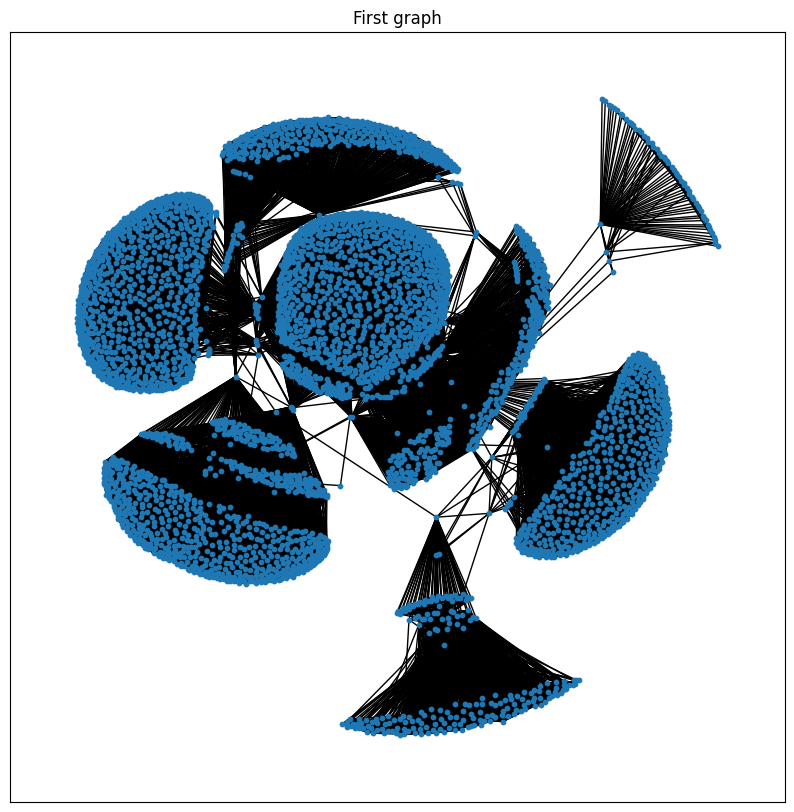

In [ ]:
Edge_graph = nx.from_edgelist(pairs)
visualize( Edge_graph, "First graph")

#Twitter

Data acquisition: indicating the data source, and how you downloaded it (Python script or IPYNB)

In [39]:
!wget https://snap.stanford.edu/data/twitter.tar.gz

--2023-10-22 15:36:33--  https://snap.stanford.edu/data/twitter.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22339604 (21M) [application/x-gzip]
Saving to: ‘twitter.tar.gz’

twitter.tar.gz      100%[===================>]  21.30M  9.33MB/s    in 2.3s    

2023-10-22 15:36:39 (9.33 MB/s) - ‘twitter.tar.gz’ saved [22339604/22339604]



In [40]:
twitter_files = ! tar xvzf twitter.tar.gz

In [41]:
T_ego_indexes = get_ego_indexes(twitter_files)

In [43]:
Twitter_graphs = []

In [44]:
for index in range(3):  #len(T_ego_indexes)-1
  f = open(f'twitter/{T_ego_indexes[index]}.edges', "rt")
  edges_str = f.readlines()
  edges = [list(map(int, item.strip().split())) for item in edges_str]
  # Transpose the data to get desired format
  edges = [list(row) for row in zip(*edges)]

  edge_list =   [(int(x.split()[0]), int(x.split()[1])) for x in edges_str]
  f = open(f'twitter/{T_ego_indexes[index]}.circles', "rt")
  circles_str = f.readlines()
  circles = [list(map(int, item.split('\t')[1:])) for item in circles_str]

  f = open(f'twitter/{T_ego_indexes[index]}.featnames', "rt")
  feat_name_str = f.readlines()
  X_names = [re.split('#|@', names)[-1].rstrip('\n-') for names in feat_name_str if '#' in names or '@' in names]


  f = open(f'twitter/{T_ego_indexes[index]}.feat', "rt")
  feat_str = f.readlines()
  X = [list(map(int, item.split()[1:])) for item in feat_str]

  f = open(f'twitter/{T_ego_indexes[index]}.egofeat', "rt")
  feat_str = f.readlines()
  X.append((map(int, feat_str[0].split()[1:])))


  # Node2Vec expects an NX graph
  G  = nx.from_edgelist(edge_list)
  # Node2Vec model specification
  n2v = Node2Vec(n_components=64, walklen=10, epochs=50, return_weight=1.0, neighbor_weight=1.0, threads=0, w2vparams={'window': 4, 'negative': 5, 'epochs':10, 'ns_exponent': 0.5, 'batch_words': 128})
  # Fit and get the embedding
  n2v.fit(G)
  nodes = G.nodes()
  embeddings = []
  for node in nodes:
    embeddings.append(n2v.predict(node))
  idx = torch.arange(len(nodes))
  train_idx, test_idx = train_test_split(idx, train_size=0.8,  random_state=17)
  val_idx, test_idx = train_test_split(test_idx, train_size=0.5,  random_state=17)


  Twitter_graphs.append(GraphData(edges, edge_list, X, circles, X_names, embeddings, nodes,  train_idx, test_idx, val_idx))

Making walks... Done, T=0.04
Mapping Walk Names... Done, T=0.22
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=2.65
Making walks... Done, T=0.02
Mapping Walk Names... Done, T=0.10
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=2.47
Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.12
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=1.53


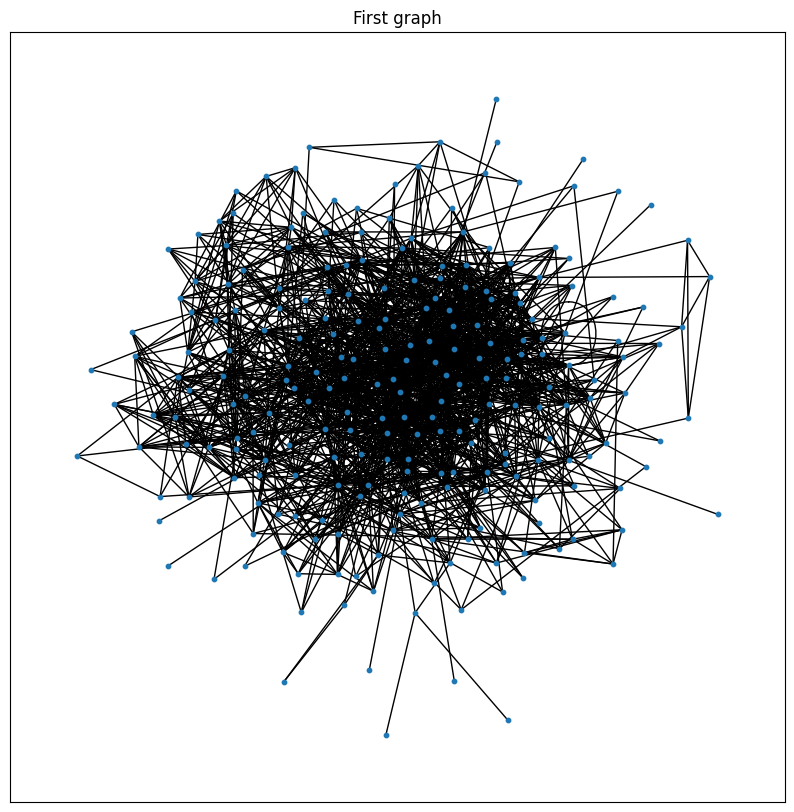

In [45]:
Edge_graph = nx.from_edgelist(Twitter_graphs[0].edge_list)
visualize( Edge_graph, "First graph")

In [46]:
Twitter_graphs[0].X[0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [47]:
Twitter_graphs[0].edge_index

[[398874773,
  18498878,
  14305022,
  22253,
  15540222,
  7415132,
  17129553,
  15911247,
  14087951,
  57378470,
  19479427,
  29294520,
  13652832,
  174958347,
  22253,
  1765921,
  14710479,
  20496869,
  13652832,
  663463,
  22253,
  3191321,
  1186,
  13141442,
  883301,
  1371101,
  1678471,
  8479062,
  14305022,
  9283582,
  728163,
  12800212,
  19094625,
  14,
  14305022,
  14710479,
  15236339,
  13462502,
  14178728,
  8479062,
  14163141,
  728163,
  17729005,
  377821426,
  15911247,
  17129553,
  15639334,
  14087951,
  713263,
  586,
  5994452,
  13019862,
  1186,
  15459980,
  47,
  380,
  6088382,
  15583257,
  16353769,
  136865608,
  10013512,
  713263,
  8630562,
  62415556,
  14819149,
  20904050,
  528,
  25583917,
  35357461,
  14710479,
  713263,
  6735,
  14087951,
  652193,
  10476462,
  883301,
  2727051,
  40198602,
  14710479,
  1566521,
  255617445,
  2372,
  551433993,
  13652832,
  17561826,
  14163141,
  17384098,
  16353769,
  57378470,
  6241555

In [49]:
Twitter_graphs[0].X_names[0:10]

[',', '...', '1', '1.', '11.', '1:', '2', '2011', '2:', '3']

In [50]:
Twitter_graphs [0].embeddings[0:10]

[array([-0.31533697, -0.5122992 , -0.20344521, -0.30582693, -0.02615228,
        -0.988196  , -0.00296489, -0.26766616, -0.09850215, -0.24579954,
         0.8193364 , -0.32172012,  1.0280381 , -0.80706936,  0.15132014,
         0.91772145,  0.36624226,  0.21779731,  1.1292677 , -0.20787771,
        -0.05225024,  0.4926841 , -0.33912307,  0.12595347,  0.20010152,
         0.22585095, -0.24416815, -0.29531366,  0.12531355, -0.02593442,
        -0.76796967,  0.43684065, -0.7661407 , -0.54274637,  0.13922028,
        -0.18764074, -0.03073184, -0.08228645,  0.2056856 ,  0.4651817 ,
        -0.50163245,  0.00585889,  0.14241134, -0.59647167,  0.48567986,
        -0.06172086,  0.28302085, -0.12141178,  0.07732907,  0.60003906,
        -0.22590916, -1.3589748 ,  0.4500132 , -0.10697953, -0.01227655,
        -0.1588613 , -0.02993609, -0.13267413, -0.51897585, -0.04926962,
         0.8182878 ,  0.17911552,  0.18868798, -0.14379138], dtype=float32),
 array([-0.01641914, -0.07487013, -0.5078927 , 